## Makemore Part 3: MLP + BN
- Code from [karpathy/nn-zero-to-hero/lectures/makemore/makemore_part3_bn.ipynb](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part3_bn.ipynb)
    - Re-factored to follow standard PyTorch workflows, while still keeping it simple and readable
    - Some additional notes / comments

### Discussion: Previous MLP Issues
- Poor initialization
    - Loss should be `-torch.tensor(1/27).log() = 3.2958` (uniform dist. at first step), but is ~27
    - Weights are too high, should be much closer to 0, but not exactly (symmetry breaking)
        - This pushes activations to values too high/low (too confident for bad pred.)
        - This causes loss to be very high on average
        - So many many iterations will be spent just reducing mag. of weights to reduce loss
- Tanh activation is saturated (-1 or +1) so grad is 0 for many values    
    - If inputs are close to 0, grad is 1, if inputs are far away, act is +/- 1 and grad is 0
    - Could lead to "dead" neurons if across entire dataset the activations are +/- 1 so grad == 0

### Discussion: Current notes

### Initialization

- Today we don't need to care too too much about initialization because we have
    - Residual connections
    - Normalization layers (batch norm, layer norm, group norm)
    - Better optimizers (RMSProp, Adam)
- For example, we can just normalize by having weights with mean = 0, var = 1/sqrt(fan_in)
    - This is ~= `torch.nn.init_kaiming_normal()` (but that uses gain=sqrt(2) versus 1 by default, where gain is set for relu)
- PyTorch default inits
    - nn.Linear: w and b are $\mathcal{U}(-\sqrt(k), \sqrt(k))$ where $k = \frac{1}{\text{in-feat}}$
    - nn.Conv2d: w and b are $\mathcal{U}(-\sqrt(k), \sqrt(k))$ where $k = \frac{1}{\text{kernel-size}\times\text{kernel-size}\times\text{in-features}}$
        - So 1x1 conv same as linear

### Normalization

- At initialization we want pre-activation logits to have unit mean/var
    - Suppose we normalize by subtracting mean and dividing by std dev to get mean=0, std = 1
    - We force every minibatch to be gaussian for EVERY iteration! aka all neurons fire everytime
    - We want network to learn to shift these distributions as necessary according to given neuron
    - We need to allow the neuron to scale and shift!
    - Initialize scale=1 and shift=0 so pre-activations are unit gaussian at init but then learn
- With more complex networks (deeper, w/ residual connections), harder to exactly set init scales
    - So normalization makes training simpler at beginning and throughout training
- As a side effect, batch norm is acting like a regularization term or data augmentation
    - Introduces a little bit of randomness / jittering based on other samples in the batch
    - Harder for the network to overfit with this
- To decouple the dependencies within a batch can use layer norm, group norm
    - But it was difficult to make the switch initially because batch norm worked well due to regularizing effect
- And what about passin in a single example during inference?
    - Need to set batch norm running mean/var during training and fix it during inference

### Imports and Paths

In [1]:
# Imports
from pathlib import Path
from typing import Optional, Callable
import functools

import torch
import torch.utils.hooks
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

# Paths (modify as necessary)
names_txt = Path('~/dl_from_scratch/dl_scratch/makemore/names.txt').expanduser()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Load Data / Build Vocabulary

### Build Dataset

In [2]:
# read in all the words
words = open(names_txt, 'r').read().splitlines()
print(f"Num words: {len(words)}")
print(f"First 10 words: {words[:10]}")

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(f"Char to int (stoi): {stoi}")
print(f"Int to char (itos): {itos}")
print(f"Vocab size: {vocab_size}")

Num words: 32033
First 10 words: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Char to int (stoi): {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
Int to char (itos): {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocab size: 27


#### Full Dataset

In [3]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words, split, x_var, y_var):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size  # Initial 
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X, device=device)
  Y = torch.tensor(Y, device=device)
  print(f"{split.capitalize()} split: {x_var}.shape: {X.shape}, {y_var}.shape: {Y.shape}")
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1], "train", "Xtr", "Ytr")    # 80%
Xdev, Ydev = build_dataset(words[n1:n2], "val", "Xdev", "Ydev")  # 10%
Xte,  Yte  = build_dataset(words[n2:], "test", "Xte", "Yte")     # 10%

Train split: Xtr.shape: torch.Size([182625, 3]), Ytr.shape: torch.Size([182625])
Val split: Xdev.shape: torch.Size([22655, 3]), Ydev.shape: torch.Size([22655])
Test split: Xte.shape: torch.Size([22866, 3]), Yte.shape: torch.Size([22866])


### Build MLP Model V1
- V1 is 2-layer MLP w/ explicit linear and batch norm with manual parameters / buffers

In [4]:
class MLPv1(nn.Module):
    def __init__(
        self,
        block_size: int = 3,  # context length
        n_embd: int = 10,  # the dimensionality of the character embedding vectors
        n_hidden: int = 200,  # the number of neurons in the hidden layer of the MLP 
        vocab_size: int = 27,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    ):
        super().__init__()
        
        self.n_embd = n_embd
        
        g = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility    
        
        # Previous MLP: Keep weights with mean=0, std=1 (default randn)
        # W1_mult = 1
        # b1_mult = 1
        # W2_mult = 1
        # b2_mult = 1
        
        # Version 1: Hard-coded values to mult by randn (initial loss: 27ish -> 3ish)
        # W1_mult = 0.2
        # b1_mult = 0.01
        # W2_mult = 0.01
        # b2_mult = 0
        
        # Version 2: Following 'Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification', Kaiming He et al 2015        
        #   - In pytorch this is torch.nn.init_kaiming_normal_(tensor, nonlinearity='relu')
        #   - For ReLU we multiply by sqrt(2) / sqrt(in_chan) == sqrt(2/in_chan)
        #   - For tanh we multiply by (5/3) / sqrt(in_chan)
        W1_mult = (5/3) / ((block_size * n_embd)**0.5)  # e.g. with (5/3)/sqrt(30) ~= 0.304
        b1_mult = 0.01
        W2_mult = 0.01
        b2_mult = 0
        
        self.C = torch.randn((vocab_size, n_embd), generator=g, device=device)  # Embedding matrix        
        self.W1 = torch.randn((block_size*n_embd, n_hidden), generator=g, device=device) * W1_mult
        # self.b1 = torch.randn(n_hidden, generator=g, device=device) * b1_mult  # No preact bias w/ bn   
        self.W2 = torch.randn((n_hidden, vocab_size), generator=g, device=device) * W2_mult
        self.b2 = torch.randn(vocab_size, generator=g, device=device) * b2_mult

        # Batch norm params; set so preactivations are unit gaussian at initialization
        self.bngain = torch.ones((1, n_hidden), device=device)  # scale, init as 1 for unit gaussian
        self.bnbias = torch.zeros((1, n_hidden), device=device)  # shift, init as 0 for unit gaussian
        
        # Batch norm buffers
        self.bnmean_running = torch.zeros((1, n_hidden), device=device)  # init running mean as 0 
        self.bnstd_running = torch.ones((1, n_hidden), device=device)  # init running std as 1

        # Hack, set requires_grad = True b/c didn't declare as nn.Parameters in this version
        parameters = self.parameters()
        for p in parameters:
            p.requires_grad = True

        print(f"Num params: {sum(p.nelement() for p in parameters)}")

    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

    def parameters(self) -> list[torch.Tensor]:
        # Hack, overwrite std impl. since we didn't declare as nn.Parameters in this version
        return [
            self.C, 
            self.W1, 
            # self.b1,  # No preact bias w/ bn
            self.W2, 
            self.b2, 
            self.bngain, 
            self.bnbias
        ]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #  x.shape; (N,L) = (32,3)
        
        # embed characters into vectors
        emb = self.C[x]  # (32, 3) -> (32, 3, 10)
        
        # concatenate the vectors
        embcat = emb.view(-1, block_size * self.n_embd)  # (32, 3, 10) -> (32, 3*10) = (32, 30)
        
        # hidden layer pre-activation >> we want this to be gaussian!
        # NOTE: bias is not necessary, they're being subtracted out when do (hpreact - bnmeani)
        hpreact = embcat @ self.W1 # + self.b1  # (32, 30) @ (30, 200) -> (32, 200)
        
        # batch norm
        # ----------
        if self.training:
            # calculate mean/std per channel (e.g. down the rows)
            bnmeani = hpreact.mean(dim=0, keepdim=True)  # (32,200) -> (1,200), mean per chan
            bnstdi = hpreact.std(dim=0, keepdim=True)  # (32,200) -> (1,200), std dev per chan
            
            # normalize
            hpreact = (hpreact - bnmeani) / (bnstdi + 1e-5)  # eps = 1e-5 to avoid divide by 0
            
            # scale and shift
            hpreact = self.bngain * hpreact + self.bnbias
            
            # update running mean/var (default "momentum" == 0.1 but that can be too high for bs=32)
            with torch.no_grad():
                momentum = 0.001
                self.bnmean_running = (1 - momentum) * self.bnmean_running + momentum * bnmeani
                self.bnstd_running = (1 - momentum) * self.bnstd_running + momentum * bnstdi
                
        else:
            # use running averages
            hpreact = (hpreact - self.bnmean_running) / self.bnstd_running            
        # ----------
        
        # hidden layer
        h = torch.tanh(hpreact)  # (32, 200) -> (32, 200)
        
        # output layer
        logits = h @ self.W2 + self.b2  #  (32, 200) @ (200, 27) -> (32, 27)
        return logits
        
    def loss(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        #  x.shape; (N,L) = (32,3)
        #  y.shape: (N,) = (32,)
        
        # forward pass to get logits / log props
        logits = self.forward(x)  # (32, 3) -> (32, 27)
        
        # loss function
        loss = F.cross_entropy(logits, y)  # (32, 27) -> (1,)
        return loss
        

### Build MLP Model V2
- V2 is 6-layer MLP w/ Linear and BatchNorm1d layers (created by us, but following real pytorch conventions)

In [120]:
class Linear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.empty((in_features, out_features)))
        self.bias = nn.Parameter(torch.empty(out_features)) if bias else None
        self.reset_parameters()

    def reset_parameters(self):
        g = torch.Generator().manual_seed(2147483647) # for reproducibility    
        self.weight.data = torch.randn((self.in_features, self.out_features), generator=g) / self.in_features**0.5
        if self.bias is not None:
            self.bias.data = torch.zeros(self.out_features)

    def forward(self, x):
        # NOTE: Only storing in .out to visualize below
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out    

class BatchNorm1d(nn.Module):

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        super().__init__()
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters (trained with backprop); init here instead of reset parameters
        self.gamma = nn.Parameter(torch.ones(dim))  # Scale
        self.beta = nn.Parameter(torch.zeros(dim))  # Shift
        
        # buffers (trained with a running 'momentum update')
        self.register_buffer('running_mean', torch.zeros(dim))
        self.register_buffer('running_var', torch.ones(dim))

    def forward(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdim=True) # batch mean (across rows, e.g. mean per chan)
            xvar = x.var(dim=0, keepdim=True) # batch variance (across rows, e.g. mean per var)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        
        # NOTE: Only storing in .out to visualize below
        self.out = self.gamma * xhat + self.beta
        
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out

class Tanh(nn.Module):    
    def forward(self, x):
        # NOTE: Only storing in .out to visualize below
        self.out = torch.tanh(x)
        return self.out    
    
class Embedding(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.weight = nn.Parameter(torch.empty(num_embeddings, embedding_dim))
        self.reset_parameters()
        
    def reset_parameters(self) -> None:
        g = torch.Generator().manual_seed(2147483647) # for reproducibility
        self.weight.data = torch.randn((self.num_embeddings, self.embedding_dim), generator=g)
        
    def forward(self, x):
        return self.weight[x]  # (N,L) -> (N,L,C)
    
class MLPv2(nn.Module):
    def __init__(
        self,
        block_size: int = 3,  # context length
        n_embd: int = 10,  # the dimensionality of the character embedding vectors
        n_hidden: int = 200,  # the number of neurons in the hidden layer of the MLP 
        vocab_size: int = 27,
        use_bn: bool = True,        
        output_gain: Optional[float] = None,  # Default 1; use 0.1 to make "less confident"
        force_linear_tanh_gain: Optional[float] = None,  # Default 5/3
    ) -> None:
        super().__init__()
        self.C = Embedding(num_embeddings=vocab_size, embedding_dim=n_embd)
        if use_bn:
            layers = [
                Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),            
                Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
                Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),            
                Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),            
                Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),            
                Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
            ]
        else:
            layers = [
                Linear(n_embd * block_size, n_hidden, bias=False), Tanh(),            
                Linear(           n_hidden, n_hidden, bias=False), Tanh(),
                Linear(           n_hidden, n_hidden, bias=False), Tanh(),            
                Linear(           n_hidden, n_hidden, bias=False), Tanh(),            
                Linear(           n_hidden, n_hidden, bias=False), Tanh(),            
                Linear(           n_hidden, vocab_size, bias=False),
            ]
            
        # See https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain
        self.output_gain = output_gain
        self.linear_tanh_gain = force_linear_tanh_gain or torch.nn.init.calculate_gain('tanh')  # 5/3
        self.layers = nn.Sequential(*layers)
        self.reset_parameters()
        
        num_params = sum(p.nelement() for p in self.parameters())
        print(f"Num params: {num_params}")
        
    def reset_parameters(self):
        # Hacky stuff, not sure why this is necessary yet
        with torch.no_grad():
            # Apply gain to linear layers
            linear_layers = [layer for layer in self.layers if isinstance(layer, Linear)]
            for idx, layer in enumerate(linear_layers):                    
                if idx < len(linear_layers) - 1:  # Non-linear, use tanh gain
                    layer.weight.data *= self.linear_tanh_gain
                else:  # Last linear layer, 
                    layer.weight.data *= torch.nn.init.calculate_gain('linear')  # 1
                    
            # Final output gain, might specify 0.1 to make less confident
            if self.output_gain is not None:
                if isinstance(self.layers[-1], Linear):
                    self.layers[-1].weight.data *= self.output_gain
                elif isinstance(self.layers[-1], BatchNorm1d):
                    self.layers[-1].gamma.data *= self.output_gain
                else:
                    assert False, "Expected output layer to be Linear or BatchNorm1d, found "
                    
    # NOTE: Don't need to redefine zero_grad when we use nn.Parameter's
                    
    def forward(self, x):
        emb = self.C(x)  # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        return self.layers(x)
    
    def loss(self, x, y):
        logits = self.forward(x)
        return F.cross_entropy(logits, y)        

### Build Hook Wrapper
- Used for visualization below to store the tensor outputs and gradients of select layers
    - See https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/#using-the-forward-hooks
    - And https://github.com/sebamenabar/Pytorch-IntermediateLayerGetter/blob/master/torch_intermediate_layer_getter/torch_intermediate_layer_getter.py
- Alternative is to store the activations in `self.out` and then call `layer.out.retain_grad()`
    - See https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part3_bn.ipynb

In [121]:
class HookWrapper:
    def __init__(
        self, 
        model: nn.Module, 
        hook_modules: type[nn.Module] | list[type[nn.Module]] | None = None,
        last_step_only: bool = True,
    ):
        self.forward_tensors: dict[str, list[torch.Tensor]] = {}
        self.backward_tensors: dict[str, list[torch.Tensor]] = {}
        
        # NOTE: Usually you should store the `torch.utils.hooks.RemovableHandle` objects that get 
        #       returned when calling `register_forward_hook()` and `register_full_backward_hook()`
        #       but in this case we will create separate models for visualization only 
            
        if hook_modules is None:
            hook_modules = []
        elif not isinstance(hook_modules, (list,tuple)):
            hook_modules = [hook_modules]
            
        def forward_hook(module, input, output, name=None):                    
            assert name is not None, 'Must set name via functools.partial when registering'
            value = output.detach().cpu()
            if last_step_only:
                self.forward_tensors[name] = [value]
            else:
                if name not in self.forward_tensors:                        
                    self.forward_tensors[name] = []
                self.forward_tensors[name].append(value)
            
        def backward_hook(module, grad_input, grad_output, name=None):
            assert name is not None, 'Must set name via functools.partial when registering'
            assert len(grad_output) == 1, "Expected single output"
            value = grad_output[0].cpu()
            if last_step_only:
                self.backward_tensors[name] = [value]
            else:
                if name not in self.backward_tensors:
                    self.backward_tensors[name] = []
                self.backward_tensors[name].append(value)
            
        for name, module in model.named_modules():
            if any([isinstance(module, hook_module) for hook_module in hook_modules]):                
                
                curr_forward_hook = functools.partial(forward_hook, name=name)
                module.register_forward_hook(curr_forward_hook)
                
                curr_backward_hook = functools.partial(backward_hook, name=name)
                module.register_full_backward_hook(curr_backward_hook)        

### Train Loop

In [122]:
def train_manual(model, max_steps = 200000, print_iter = 10000, lr=0.1):
    stepi = []
    lossi = []
    ud = []

    # Set training mode for batch norm!
    model.train()
    
    for i in tqdm(range(max_steps), desc="iter", total=max_steps):
    
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (32,))  # (32,)
        x = Xtr[ix]  # (32, 3) or (32, block_size)
        y = Ytr[ix]
        
        # forward pass
        loss = model.loss(x, y)
        
        # backward pass
        model.zero_grad()
        loss.backward()
        
        # update
        cur_lr = lr if i < 0.8 * max_steps else lr/10
        for p in model.parameters():
            p.data += -cur_lr * p.grad  # pyright: ignore[reportOperatorIssue]

        # track stats
        stepi.append(i)
        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append(
                [
                    ((lr*p.grad).std() / p.data.std()).log10().item()  # std grad / std data
                    for p in model.parameters()
                ]
            )
        
        # print
        if i == 0 or (i+1) % print_iter == 0:
            print(f"Iter [{i+1}/{max_steps}]: loss={loss.item():.3f}, lr={lr}")

    print(f"Final loss: {loss.item()}")
    return stepi, lossi, ud

In [123]:
def train_adam(model, max_steps = 200000, print_iter = 10000, lr=1e-4):
    stepi = []
    lossi = []
    ud = []

    optimizer = optim.Adam(params=model.parameters(), lr=lr)  # pyright: ignore[reportPrivateImportUsage]

    scheduler_steps = max(1, int(0.8 * max_steps))
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=scheduler_steps, gamma=0.1)

    # Set training mode for batch norm!
    model.train()
    
    for i in tqdm(range(max_steps), desc="iter", total=max_steps):
    
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (32,))  # (32,)
        x = Xtr[ix]  # (32, 3) or (32, block_size)
        y = Ytr[ix]
        
        # forward pass
        loss = model.loss(x, y)
        
        # backward pass        
        model.zero_grad()
        loss.backward()
        
        # update
        optimizer.step()
        scheduler.step()
                
        # track stats
        stepi.append(i)
        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append(
                [
                    ((lr*p.grad).std() / p.data.std()).log10().item()  # std grad / std data
                    for p in model.parameters()
                ]
            )
        
        # print
        if i == 0 or (i+1) % print_iter == 0:
            print(f"Iter [{i+1}/{max_steps}]: loss={loss.item():.3f}, lr={optimizer.param_groups[0]['lr']}")

    print(f"Final loss: {loss.item()}")
    return stepi, lossi, ud

In [124]:
# Build and train model
def train_model(
    model_str: str, 
    train_fn: Callable, 
    max_steps=100000, 
    print_iter=10000, 
    hook_modules=Tanh,
    model_kwargs=dict(),
    train_kwargs=dict()
):
    n_embd = 10  # the dimensionality of the character embedding vectors
    n_hidden = 200  # the number of neurons in the hidden layer of the MLP
    if model_str == "MLPv1":
        model = MLPv1(
            block_size=block_size,  # e.g. 3 above
            n_embd=n_embd,
            n_hidden=n_hidden,  
            vocab_size=vocab_size,
            **model_kwargs,
        )
    elif model_str == "MLPv2":
        model = MLPv2(
            block_size=block_size,
            n_embd=n_embd,
            n_hidden=n_hidden,
            vocab_size=vocab_size,
            **model_kwargs,
        )
        model.to(device)  # For v2 we move everything to device after
    else:
        assert False, "Expected model_str in ['MLPv1', 'MLPv2']"
        
    # Use HookWrapper to store intermediate activations/grads
    hook_wrapper = None
    if hook_modules is not None:
        hook_wrapper = HookWrapper(model, hook_modules) 

    print(f"- " * 30)
    print(f"Training {model.__class__.__name__} via {train_fn.__name__}()")
    print(f"- " * 30)
    stepi, lossi, ud = train_fn(model, max_steps=max_steps, print_iter=print_iter, **train_kwargs)
    print(f"- " * 30)
    
    return model, hook_wrapper, stepi, lossi, ud  # For visualization


In [11]:
max_steps = 100000  # 100k steps for faster testing
model_v1_manual, _wrapper, _step, model_v1_manual_loss, _ud = train_model(
    model_str="MLPv1", train_fn=train_manual, max_steps=max_steps
)

Num params: 12097
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training MLPv1 via train_manual()
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


iter:   0%|          | 6/100000 [00:00<28:55, 57.62it/s]

Iter [1/100000]: loss=3.290, lr=0.1


iter:  10%|█         | 10064/100000 [00:30<04:24, 340.28it/s]

Iter [10000/100000]: loss=2.519, lr=0.1


iter:  20%|██        | 20056/100000 [01:00<03:58, 334.97it/s]

Iter [20000/100000]: loss=2.490, lr=0.1


iter:  30%|███       | 30063/100000 [01:33<03:50, 302.88it/s]

Iter [30000/100000]: loss=2.286, lr=0.1


iter:  40%|████      | 40049/100000 [02:05<03:06, 321.53it/s]

Iter [40000/100000]: loss=2.610, lr=0.1


iter:  50%|█████     | 50045/100000 [02:38<02:44, 302.92it/s]

Iter [50000/100000]: loss=2.460, lr=0.1


iter:  60%|██████    | 60042/100000 [03:12<02:14, 297.46it/s]

Iter [60000/100000]: loss=2.089, lr=0.1


iter:  70%|███████   | 70042/100000 [03:46<01:37, 306.43it/s]

Iter [70000/100000]: loss=2.364, lr=0.1


iter:  80%|████████  | 80055/100000 [04:21<01:08, 293.21it/s]

Iter [80000/100000]: loss=2.033, lr=0.1


iter:  90%|█████████ | 90056/100000 [04:55<00:32, 303.72it/s]

Iter [90000/100000]: loss=2.256, lr=0.01


iter: 100%|██████████| 100000/100000 [05:28<00:00, 304.73it/s]

Iter [100000/100000]: loss=2.291, lr=0.01
Final loss: 2.2906863689422607
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [29]:
model_v1_adam, _wrapper, _step, model_v1_adam_loss, _ud = train_model(
    model_str="MLPv1", train_fn=train_adam, max_steps=max_steps,
)

Num params: 12097
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training MLPv1 via train_adam()
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


iter:   0%|          | 15/100000 [00:00<11:13, 148.43it/s]

Iter [1/100000]: loss=3.336, lr=0.0001


iter:  10%|█         | 10034/100000 [00:33<04:52, 307.85it/s]

Iter [10000/100000]: loss=2.264, lr=0.0001


iter:  20%|██        | 20044/100000 [01:08<04:24, 301.76it/s]

Iter [20000/100000]: loss=2.490, lr=0.0001


iter:  30%|███       | 30050/100000 [01:44<03:57, 294.36it/s]

Iter [30000/100000]: loss=2.456, lr=0.0001


iter:  40%|████      | 40035/100000 [02:19<03:19, 300.56it/s]

Iter [40000/100000]: loss=2.319, lr=0.0001


iter:  50%|█████     | 50062/100000 [02:53<02:55, 285.32it/s]

Iter [50000/100000]: loss=2.189, lr=0.0001


iter:  60%|██████    | 60028/100000 [03:27<02:41, 246.80it/s]

Iter [60000/100000]: loss=2.705, lr=0.0001


iter:  70%|███████   | 70056/100000 [04:01<01:35, 314.59it/s]

Iter [70000/100000]: loss=1.826, lr=0.0001


iter:  80%|████████  | 80057/100000 [04:35<01:06, 298.14it/s]

Iter [80000/100000]: loss=2.199, lr=1e-05


iter:  90%|█████████ | 90056/100000 [05:08<00:30, 325.22it/s]

Iter [90000/100000]: loss=2.484, lr=1e-05


iter: 100%|██████████| 100000/100000 [05:41<00:00, 292.63it/s]

Iter [100000/100000]: loss=1.995, lr=1e-05
Final loss: 1.9946128129959106
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [13]:
model_v2_manual, _wrapper, _step, model_v2_manual_loss, _ud = train_model(
    model_str="MLPv2", train_fn=train_manual, max_steps=max_steps
)

Num params: 173724
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training MLPv2 via train_manual()
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


iter:   0%|          | 0/100000 [00:00<?, ?it/s]

iter:   0%|          | 8/100000 [00:00<22:31, 73.99it/s]

Iter [1/100000]: loss=3.334, lr=0.1


iter:  10%|█         | 10017/100000 [01:38<13:39, 109.74it/s]

Iter [10000/100000]: loss=2.268, lr=0.1


iter:  20%|██        | 20014/100000 [03:21<14:18, 93.14it/s] 

Iter [20000/100000]: loss=2.437, lr=0.1


iter:  30%|███       | 30017/100000 [05:00<11:14, 103.70it/s]

Iter [30000/100000]: loss=2.456, lr=0.1


iter:  40%|████      | 40022/100000 [06:32<08:49, 113.32it/s]

Iter [40000/100000]: loss=1.460, lr=0.1


iter:  50%|█████     | 50013/100000 [08:06<07:50, 106.24it/s]

Iter [50000/100000]: loss=2.035, lr=0.1


iter:  60%|██████    | 60014/100000 [10:00<08:12, 81.26it/s] 

Iter [60000/100000]: loss=1.924, lr=0.1


iter:  70%|███████   | 70016/100000 [11:57<05:07, 97.54it/s] 

Iter [70000/100000]: loss=1.977, lr=0.1


iter:  80%|████████  | 80016/100000 [13:34<02:57, 112.59it/s]

Iter [80000/100000]: loss=1.807, lr=0.1


iter:  90%|█████████ | 90015/100000 [15:13<01:27, 114.25it/s]

Iter [90000/100000]: loss=2.036, lr=0.01


iter: 100%|██████████| 100000/100000 [16:44<00:00, 99.52it/s]

Iter [100000/100000]: loss=1.994, lr=0.01
Final loss: 1.993695855140686
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [30]:
model_v2_adam, _wrapper, _step, model_v2_adam_loss, _ud = train_model(
    model_str="MLPv2", train_fn=train_adam, max_steps=max_steps
)

Num params: 173724
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training MLPv2 via train_adam()
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


iter:   0%|          | 0/100000 [00:00<?, ?it/s]

Iter [1/100000]: loss=3.734, lr=0.0001


iter:  10%|█         | 10015/100000 [01:42<15:06, 99.25it/s] 

Iter [10000/100000]: loss=2.472, lr=0.0001


iter:  20%|██        | 20014/100000 [03:20<16:16, 81.93it/s] 

Iter [20000/100000]: loss=2.033, lr=0.0001


iter:  30%|███       | 30014/100000 [05:00<15:51, 73.58it/s] 

Iter [30000/100000]: loss=2.133, lr=0.0001


iter:  40%|████      | 40017/100000 [06:36<09:42, 102.97it/s]

Iter [40000/100000]: loss=2.199, lr=0.0001


iter:  50%|█████     | 50017/100000 [08:16<08:09, 102.19it/s]

Iter [50000/100000]: loss=2.287, lr=0.0001


iter:  60%|██████    | 60012/100000 [09:55<06:17, 105.81it/s]

Iter [60000/100000]: loss=1.961, lr=0.0001


iter:  70%|███████   | 70017/100000 [11:37<04:44, 105.46it/s]

Iter [70000/100000]: loss=2.163, lr=0.0001


iter:  80%|████████  | 80015/100000 [13:20<03:09, 105.47it/s]

Iter [80000/100000]: loss=2.023, lr=1e-05


iter:  90%|█████████ | 90018/100000 [15:04<01:38, 101.40it/s]

Iter [90000/100000]: loss=1.815, lr=1e-05


iter: 100%|██████████| 100000/100000 [16:46<00:00, 99.36it/s]


Iter [100000/100000]: loss=1.976, lr=1e-05
Final loss: 1.9758515357971191
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


### Evaluate and Generate

In [32]:
def evaluate(model):
    # Set to eval mode for running mean/var!
    model.eval()
    
    @torch.no_grad() # this decorator disables gradient tracking
    def split_loss(split, X, Y):   
        
        loss = model.loss(X, Y)    
        print(f"{split.capitalize()} loss: {loss.item()}")

    split_loss('train', Xtr, Ytr)
    split_loss('val', Xdev, Ydev)

In [ ]:
def generate(model):
    # sample from the model
    g = torch.Generator(device=device).manual_seed(2147483647 + 10)

    model.eval()
    for _ in range(20):
        out = []
        context = [0] * block_size  # initialize with `...`
        while True:    
            x = torch.tensor([context], device=device)  # (1,block_size)
            logits = model.forward(x)  # (1,block_size) -> (1,27)
            
            probs = F.softmax(logits, dim=-1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
        
        print(''.join(itos[i] for i in out))

In [33]:
evaluate(model_v2_adam)

Train loss: 2.04288649559021
Val loss: 2.096742868423462


In [35]:
generate(model_v2_adam)

brent.
shyzen.
keirandra.
hardrone.
breidzy.
murah.
emin.
jacy.
adge.
wylla.
frmel.
tayellohita.
stetgetten.
gendyn.
zazerann.
jullana.
doria.
davel.
mikhellowyson.
kathikpbran.


### Visualizing Activations, Gradients and Parameters

In [74]:
# Visualize activations
def visualize_act(hook_wrapper, module=Tanh, prepend_str=""):
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for name, t_list in hook_wrapper.forward_tensors.items():
        t = t_list[-1]        
        saturated = (t.abs() > 0.97).float().mean()*100
        print(f'name: {name} ({module.__name__}), mean: {t.mean():+.2f}, std: {t.std():.2f}, saturated: {saturated:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1], hy)
        legends.append(f'{name} ({module.__name__})')
    plt.legend(legends)
    plt.title(f'{prepend_str} activation distribution')

In [75]:
# Visualize gradients
def visualize_grad(hook_wrapper, module=Tanh, prepend_str=""):
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for name in hook_wrapper.forward_tensors.keys():  # Forward has names in correct order
        t_list = hook_wrapper.backward_tensors[name]
        t = t_list[-1]        
        print(f'name: {name} ({module.__name__}), mean: {t.mean():+.2f}, std: {t.std():.2f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1], hy)
        legends.append(f'{name} ({module.__name__})')
    plt.legend(legends)
    plt.title(f'{prepend_str} gradient distribution')

In [105]:
# Visualize parameters
def visualize_params(model, prepend_str=""):
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i, p in enumerate(model.parameters()):
        t = p.grad.cpu()
        if p.ndim == 2:  # Only 2D params, so weights of embedding and linear layers
            print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'{i} {tuple(p.shape)}')
        plt.legend(legends)
        plt.title(f'{prepend_str} weights gradient distribution')

In [108]:
# Visualize data grad update / data update ratio (ratio of std dev)
def visualize_update_ratio(model, ud, prepend_str=""):
    plt.figure(figsize=(20, 4))
    legends = []
    for i,p in enumerate(model.parameters()):
        if p.ndim == 2:  # Only 2D params, so weights of embedding and linear layers
            plt.plot([ud[j][i] for j in range(len(ud))])
            legends.append('param %d' % i)
    plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
    plt.legend(legends)
    plt.title(f'{prepend_str} (lr*p.grad).std() / p.data.std()).log10()')

#### Visualize Part A: No BN, Gain=5/3
- Single step (`max_steps=1`)
- No bn (`use_bn=False`)
- Reduce last linear weight init: `output_gain=0.1` (less confident)
- Mult. other linear weight init: `force_linear_tanh_gain=5/3` (default tanh gain)

In [132]:
# Forward pass
model, hook_wrapper, step, loss, ud = train_model(
    model_str="MLPv2", 
    train_fn=train_manual, 
    max_steps=1, 
    model_kwargs=dict(use_bn=False, output_gain=0.1, force_linear_tanh_gain=5/3),  
)

Num params: 171670
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training MLPv2 via train_manual()
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


iter: 100%|██████████| 1/1 [00:00<00:00, 32.93it/s]

Iter [1/1]: loss=3.296, lr=0.1
Final loss: 3.29638409614563
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


name: layers.1 (Tanh), mean: -0.01, std: 0.75, saturated: 18.92%
name: layers.3 (Tanh), mean: -0.01, std: 0.70, saturated: 10.19%
name: layers.5 (Tanh), mean: +0.04, std: 0.68, saturated: 8.00%
name: layers.7 (Tanh), mean: -0.00, std: 0.67, saturated: 7.47%
name: layers.9 (Tanh), mean: +0.01, std: 0.66, saturated: 5.73%


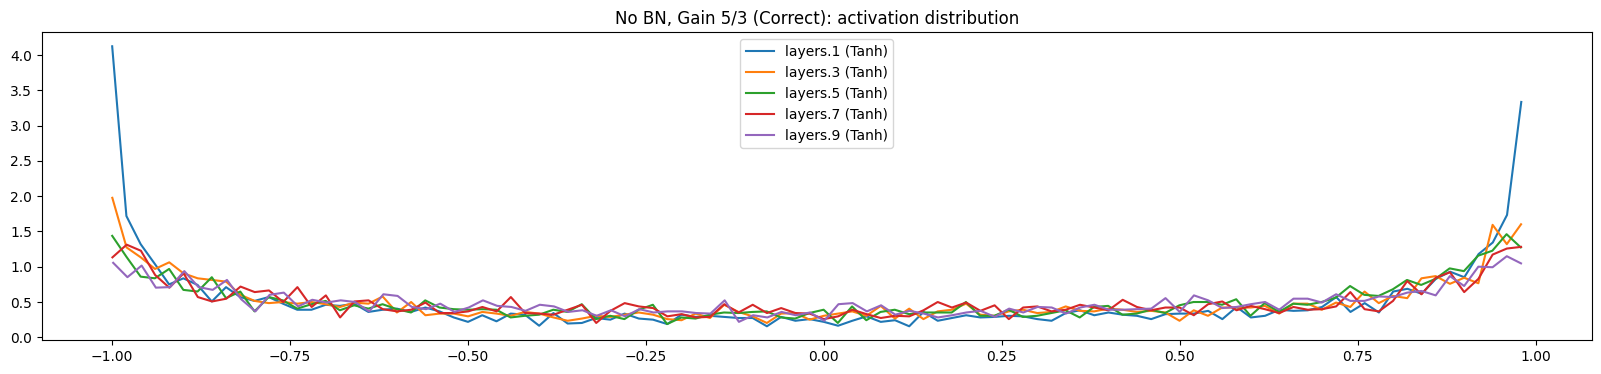

In [133]:
# Visualize activations
visualize_act(hook_wrapper, prepend_str="No BN, Gain 5/3 (Correct):")

name: layers.1 (Tanh), mean: +0.00, std: 0.00
name: layers.3 (Tanh), mean: +0.00, std: 0.00
name: layers.5 (Tanh), mean: -0.00, std: 0.00
name: layers.7 (Tanh), mean: -0.00, std: 0.00
name: layers.9 (Tanh), mean: +0.00, std: 0.00


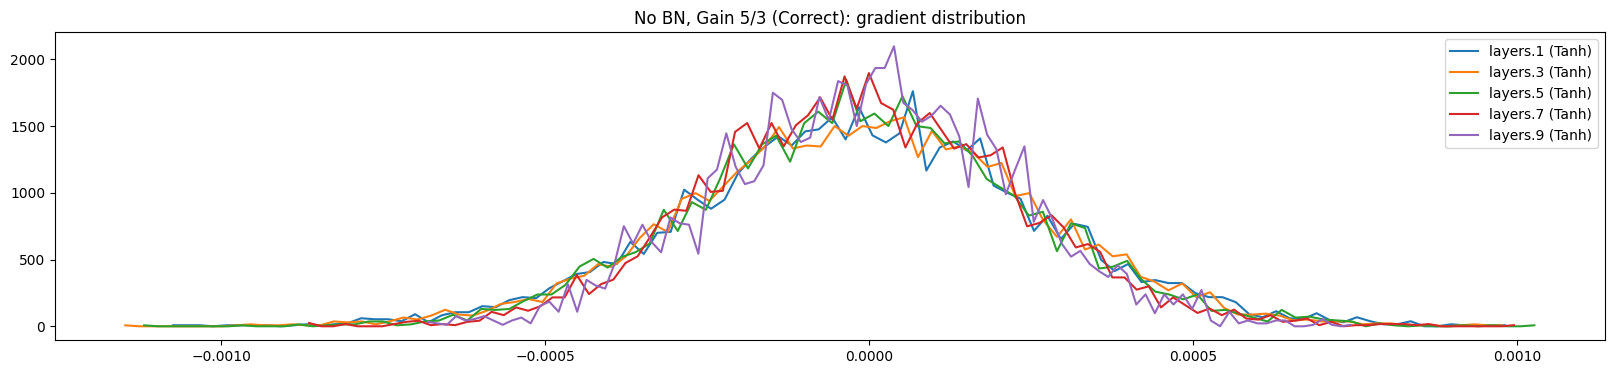

In [134]:
visualize_grad(hook_wrapper, prepend_str="No BN, Gain 5/3 (Correct):")

weight   (27, 10) | mean -0.000046 | std 1.132851e-03 | grad:data ratio 1.132032e-03
weight  (30, 200) | mean -0.000008 | std 8.536878e-04 | grad:data ratio 2.798567e-03
weight (200, 200) | mean +0.000001 | std 7.708365e-04 | grad:data ratio 6.545560e-03
weight (200, 200) | mean -0.000002 | std 6.850269e-04 | grad:data ratio 5.816903e-03
weight (200, 200) | mean +0.000002 | std 6.581366e-04 | grad:data ratio 5.588565e-03
weight (200, 200) | mean -0.000003 | std 6.551457e-04 | grad:data ratio 5.563169e-03
weight  (200, 27) | mean -0.000000 | std 2.595624e-02 | grad:data ratio 3.427604e+00


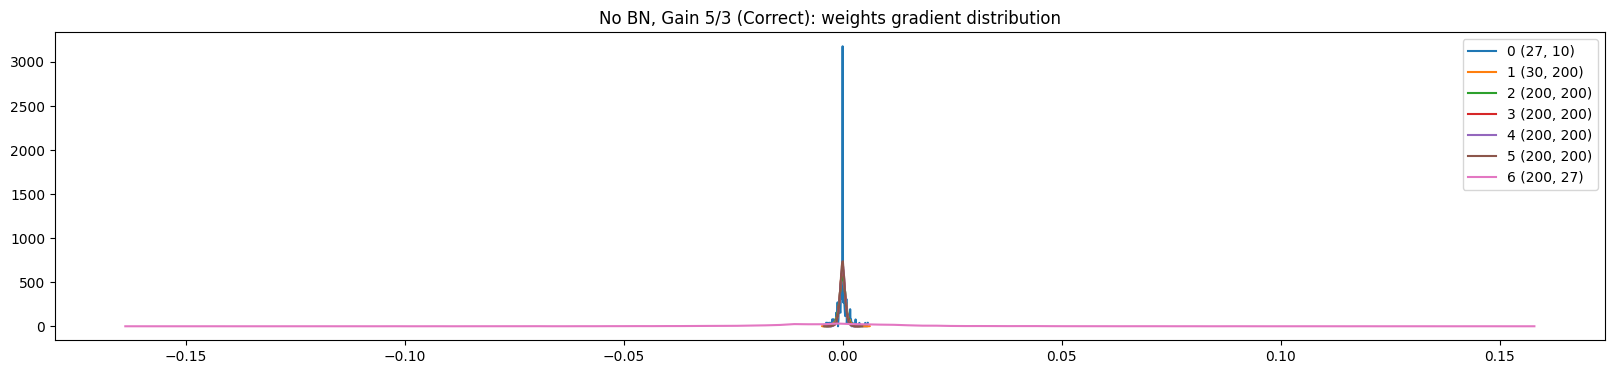

In [135]:
# Want grad:data ratios of around 1e-3
visualize_params(model, prepend_str="No BN, Gain 5/3 (Correct):")

Num params: 171670
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training MLPv2 via train_manual()
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


iter:   0%|          | 0/1000 [00:00<?, ?it/s]

iter:   0%|          | 4/1000 [00:00<00:26, 37.85it/s]

Iter [1/1000]: loss=3.289, lr=0.1


iter: 100%|██████████| 1000/1000 [00:07<00:00, 137.59it/s]


Final loss: 2.427253246307373
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


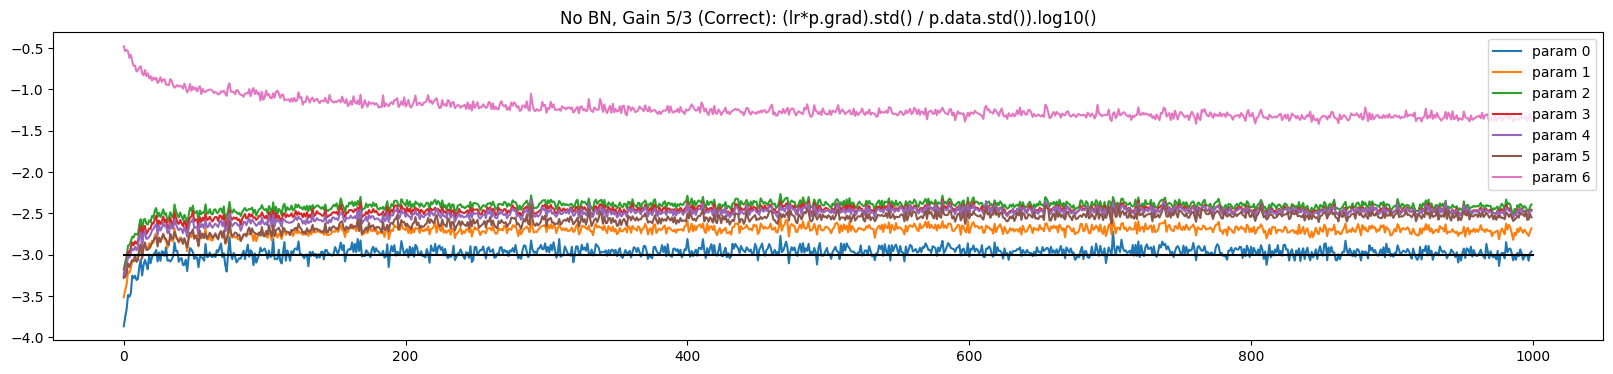

In [137]:
# Use 1000 steps for update (ud)
model, hook_wrapper, step, loss, ud = train_model(
    model_str="MLPv2", 
    train_fn=train_manual,
    max_steps=1000, 
    model_kwargs=dict(use_bn=False, output_gain=0.1, force_linear_tanh_gain=5/3),  
)
visualize_update_ratio(model=model, ud=ud, prepend_str="No BN, Gain 5/3 (Correct):")

- **With no BN but correct gain**:
    - Bad: First layer pretty saturated
    - Good: Following layers stabilize b/c gain counters act squashing from saturated tanh
    - Good: Gradients are relatively diffuse / not too peaked
    - Neutral: Output layer weights (pink, shape (200,27)) has weights w/ std dev a bit large
        - But update isn't too bad, most lines are close to 1e-3 update ratio

#### Visualize Part A: No BN, Gain=0.5
- Single step (`max_steps=1`)
- No bn (`use_bn=False`)
- Reduce last linear weight init: `output_gain=0.1` (less confident)
- Mult. other linear weight init: `force_linear_tanh_gain=1` (gain too small for tanh)

In [155]:
# Forward pass
model, hook_wrapper, step, loss, ud = train_model(
    model_str="MLPv2", 
    train_fn=train_manual, 
    max_steps=1, 
    model_kwargs=dict(use_bn=False, output_gain=0.1, force_linear_tanh_gain=0.5),  
)

Num params: 171670
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training MLPv2 via train_manual()
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


iter:   0%|          | 0/1 [00:00<?, ?it/s]

iter: 100%|██████████| 1/1 [00:00<00:00, 40.67it/s]

Iter [1/1]: loss=3.296, lr=0.1
Final loss: 3.296356678009033
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


name: layers.1 (Tanh), mean: -0.02, std: 0.40, saturated: 0.00%
name: layers.3 (Tanh), mean: +0.00, std: 0.19, saturated: 0.00%
name: layers.5 (Tanh), mean: +0.00, std: 0.10, saturated: 0.00%
name: layers.7 (Tanh), mean: -0.00, std: 0.05, saturated: 0.00%
name: layers.9 (Tanh), mean: -0.00, std: 0.02, saturated: 0.00%


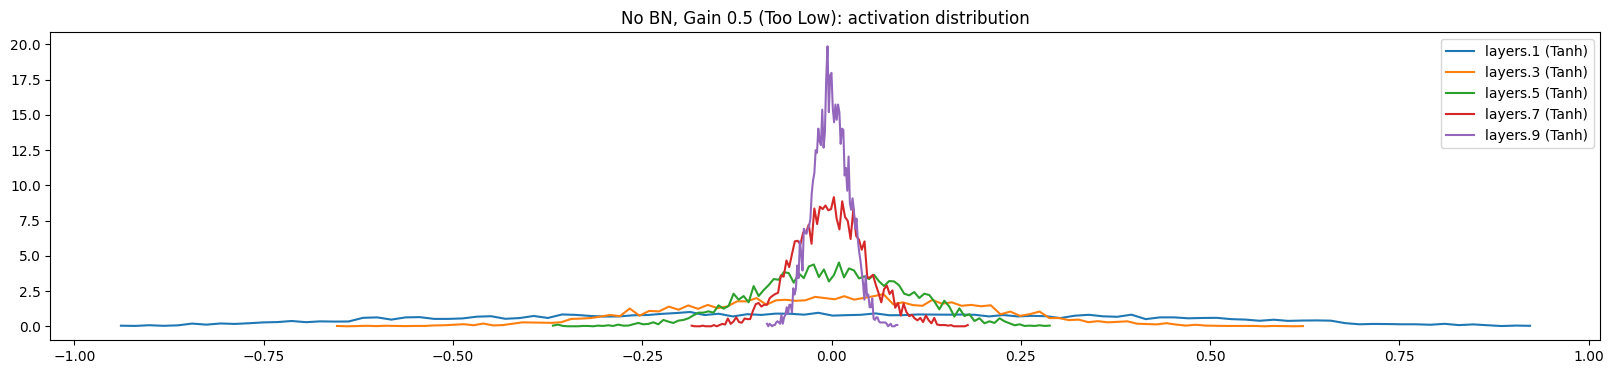

In [156]:
# Visualize activations
visualize_act(hook_wrapper, prepend_str="No BN, Gain 0.5 (Too Low):")

name: layers.1 (Tanh), mean: -0.00, std: 0.00
name: layers.3 (Tanh), mean: +0.00, std: 0.00
name: layers.5 (Tanh), mean: +0.00, std: 0.00
name: layers.7 (Tanh), mean: +0.00, std: 0.00
name: layers.9 (Tanh), mean: -0.00, std: 0.00


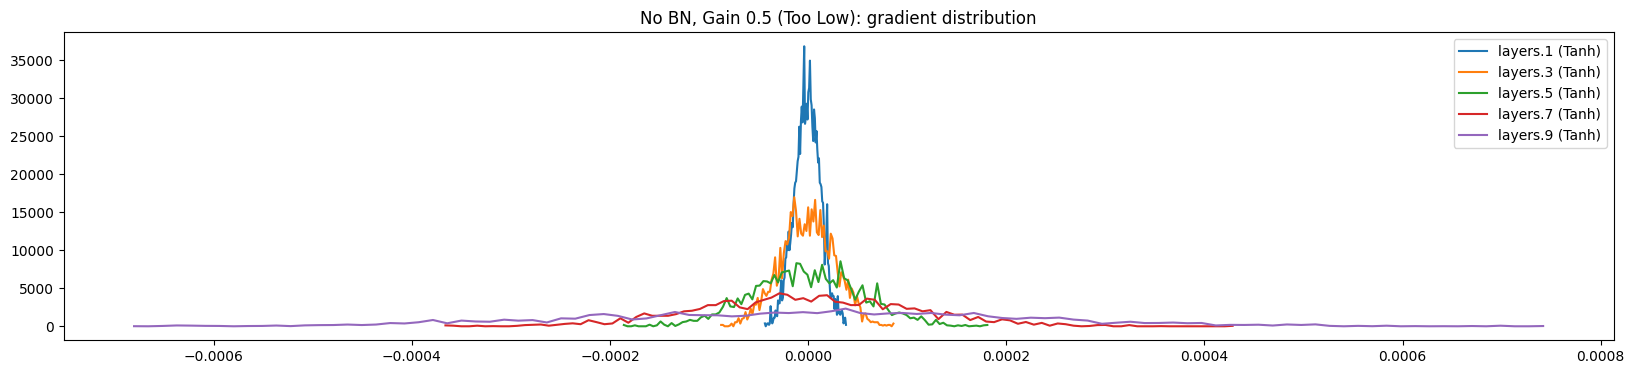

In [157]:
# Visualize activations
visualize_grad(hook_wrapper, prepend_str="No BN, Gain 0.5 (Too Low):")

- **With no BN and gain too low**:
    - Good: No saturation
    - Bad: activations in later layers are approaching zero (vanishing activations)
    - Bad: gradients in earlier layers are close to zero, then expanding (weird)

#### Visualize Part A: No BN, Gain=3
- Single step (`max_steps=1`)
- No bn (`use_bn=False`)
- Reduce last linear weight init: `output_gain=0.1` (less confident)
- Mult. other linear weight init: `force_linear_tanh_gain=3` (gain too large for tanh)

In [160]:
# Forward pass
model, hook_wrapper, step, loss, ud = train_model(
    model_str="MLPv2", 
    train_fn=train_manual, 
    max_steps=1, 
    model_kwargs=dict(use_bn=False, output_gain=0.1, force_linear_tanh_gain=3),  
)

Num params: 171670
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training MLPv2 via train_manual()
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


iter: 100%|██████████| 1/1 [00:00<00:00, 38.96it/s]

Iter [1/1]: loss=3.323, lr=0.1
Final loss: 3.322993278503418
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


name: layers.1 (Tanh), mean: -0.03, std: 0.85, saturated: 45.11%
name: layers.3 (Tanh), mean: +0.02, std: 0.84, saturated: 42.50%
name: layers.5 (Tanh), mean: +0.02, std: 0.84, saturated: 42.08%
name: layers.7 (Tanh), mean: -0.02, std: 0.84, saturated: 40.50%
name: layers.9 (Tanh), mean: -0.00, std: 0.84, saturated: 40.47%


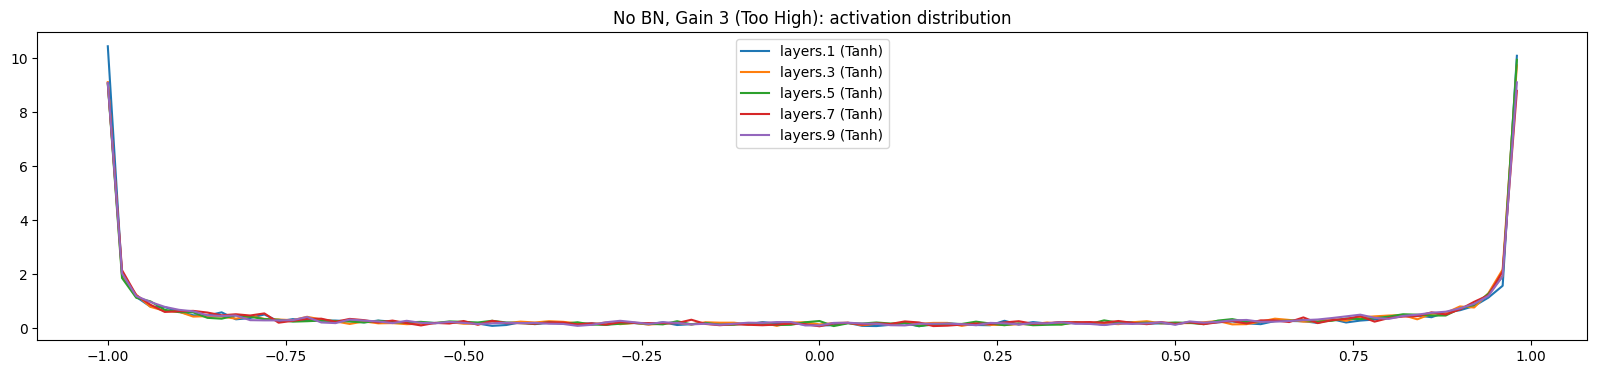

In [161]:
# Visualize activations
visualize_act(hook_wrapper, prepend_str="No BN, Gain 3 (Too High):")

name: layers.1 (Tanh), mean: -0.00, std: 0.00
name: layers.3 (Tanh), mean: -0.00, std: 0.00
name: layers.5 (Tanh), mean: -0.00, std: 0.00
name: layers.7 (Tanh), mean: -0.00, std: 0.00
name: layers.9 (Tanh), mean: -0.00, std: 0.00


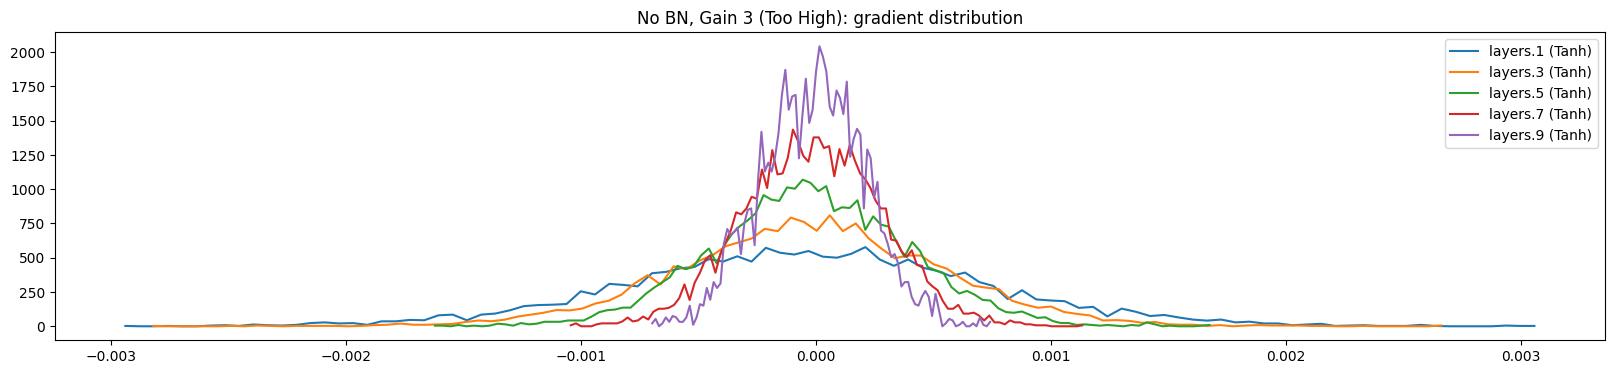

In [162]:
# Visualize activations
visualize_grad(hook_wrapper, prepend_str="No BN, Gain 3 (Too High):")

- **With no BN and gain too high**:
    - Bad: All layers become saturated
    - Bad: Gradients vanish (become zero)    

#### Visualize Part A: No BN Conclusion
- Difficult to properly set gain, network is quite sensitive to it at the start
- In general we have "asymmetry" 
    - Activations aren't consistent in forward pass
    - Gradients aren't consistent in backward pass

#### Visualize Part B: With BN, Gain=5/3
- Single step (`max_steps=1`)
- With bn (`use_bn=False`)
- Reduce last linear weight init: `output_gain=0.1` (less confident)
- Mult. other linear weight init: `force_linear_tanh_gain=5/3` (default tanh gain)

In [138]:
# Forward pass
model, hook_wrapper, step, loss, ud = train_model(
    model_str="MLPv2", 
    train_fn=train_manual, 
    max_steps=1, 
    model_kwargs=dict(use_bn=True, output_gain=0.1, force_linear_tanh_gain=5/3),  
)

Num params: 173724
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training MLPv2 via train_manual()
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


iter:   0%|          | 0/1 [00:00<?, ?it/s]

iter: 100%|██████████| 1/1 [00:00<00:00, 15.77it/s]

Iter [1/1]: loss=3.278, lr=0.1
Final loss: 3.2780284881591797
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


name: layers.2 (Tanh), mean: +0.00, std: 0.63, saturated: 2.97%
name: layers.5 (Tanh), mean: +0.00, std: 0.64, saturated: 2.59%
name: layers.8 (Tanh), mean: +0.00, std: 0.64, saturated: 2.34%
name: layers.11 (Tanh), mean: +0.01, std: 0.63, saturated: 2.45%
name: layers.14 (Tanh), mean: -0.00, std: 0.63, saturated: 2.56%


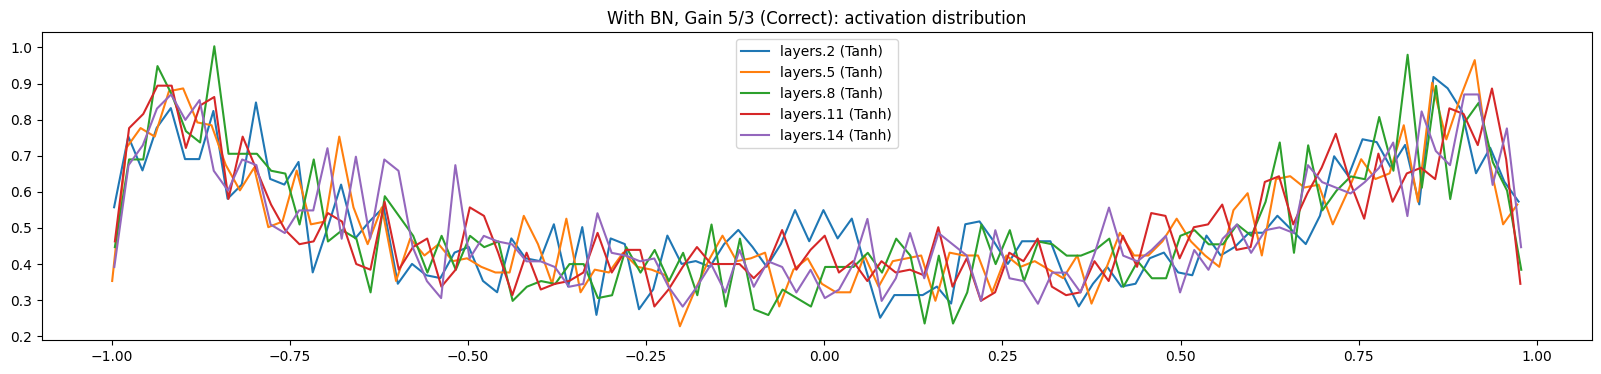

In [139]:
# Visualize activations
visualize_act(hook_wrapper, prepend_str="With BN, Gain 5/3 (Correct):")

name: layers.2 (Tanh), mean: -0.00, std: 0.00
name: layers.5 (Tanh), mean: -0.00, std: 0.00
name: layers.8 (Tanh), mean: +0.00, std: 0.00
name: layers.11 (Tanh), mean: +0.00, std: 0.00
name: layers.14 (Tanh), mean: -0.00, std: 0.00


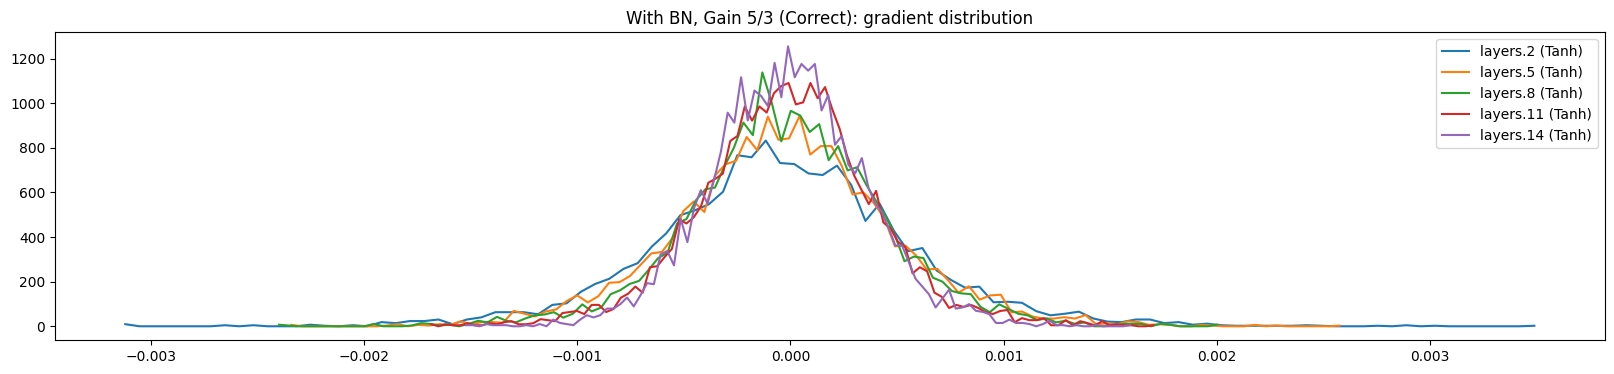

In [140]:
visualize_grad(hook_wrapper, prepend_str="With BN, Gain 5/3 (Correct):")

weight   (27, 10) | mean +0.000000 | std 2.119536e-03 | grad:data ratio 2.118003e-03
weight  (30, 200) | mean -0.000020 | std 1.422735e-03 | grad:data ratio 4.664024e-03
weight (200, 200) | mean +0.000003 | std 1.150992e-03 | grad:data ratio 9.773647e-03
weight (200, 200) | mean -0.000003 | std 9.781999e-04 | grad:data ratio 8.306384e-03
weight (200, 200) | mean +0.000001 | std 8.860664e-04 | grad:data ratio 7.524033e-03
weight (200, 200) | mean +0.000004 | std 8.087415e-04 | grad:data ratio 6.867430e-03
weight  (200, 27) | mean -0.000003 | std 3.256339e-03 | grad:data ratio 4.572907e-02


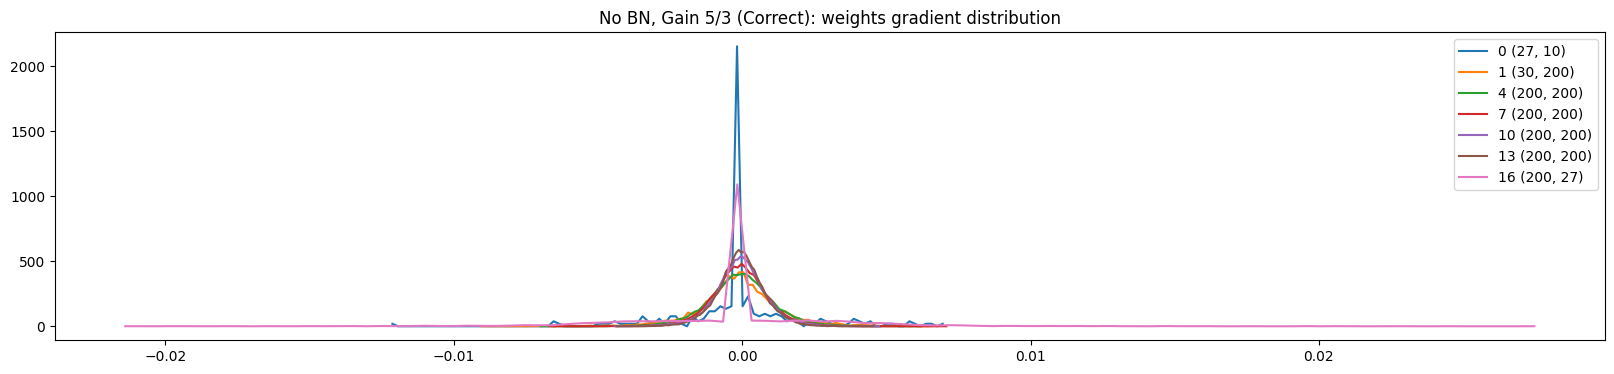

In [141]:
# Want grad:data ratios of around 1e-3
visualize_params(model, prepend_str="No BN, Gain 5/3 (Correct):")

Num params: 171670
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training MLPv2 via train_manual()
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


iter:   0%|          | 0/1000 [00:00<?, ?it/s]

iter:   0%|          | 4/1000 [00:00<00:30, 32.96it/s]

Iter [1/1000]: loss=3.290, lr=0.1


iter: 100%|██████████| 1000/1000 [00:07<00:00, 140.71it/s]


Final loss: 2.1696979999542236
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


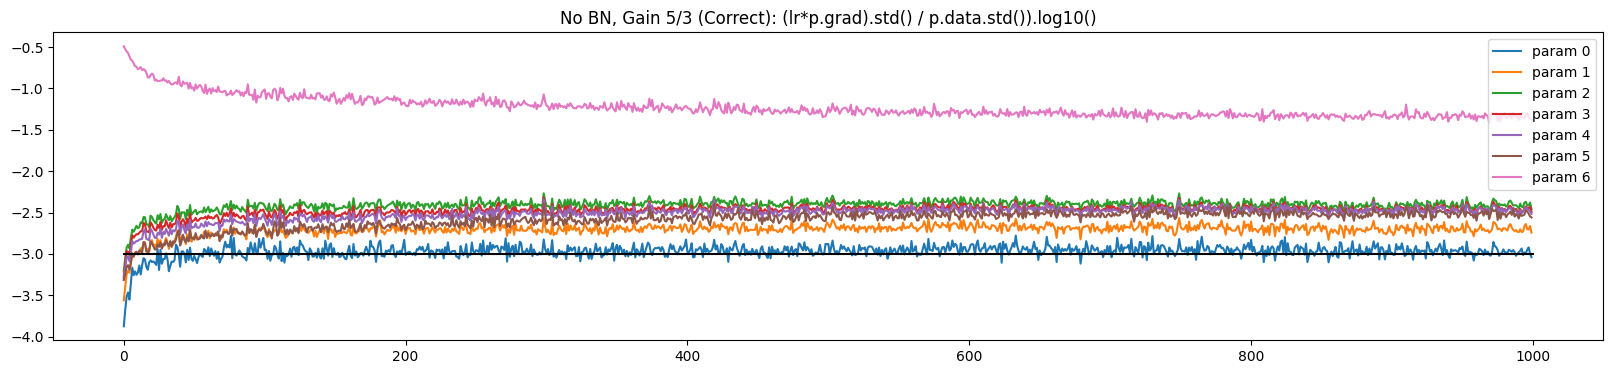

In [142]:
# Use 1000 steps for update (ud)
model, hook_wrapper, step, loss, ud = train_model(
    model_str="MLPv2", 
    train_fn=train_manual,
    max_steps=1000, 
    model_kwargs=dict(use_bn=False, output_gain=0.1, force_linear_tanh_gain=5/3),  
)
visualize_update_ratio(model=model, ud=ud, prepend_str="No BN, Gain 5/3 (Correct):")

- **With BN and correct gain**:
    - Good: Very few saturated neurons, consistent activations
    - Good: Consistent gradients, not too peaked
    - Neutral: Output layer weights (pink, shape (200,27)) has weights w/ std dev a bit large
        - But update isn't too bad, most lines are close to 1e-3 update ratio

#### Visualize Part B: With BN, Gain=0.5
- Single step (`max_steps=1`)
- With bn (`use_bn=True`)
- Reduce last linear weight init: `output_gain=0.1` (less confident)
- Mult. other linear weight init: `force_linear_tanh_gain=1` (gain too small for tanh)

In [95]:
# Forward pass
model, hook_wrapper, step, loss, ud = train_model(
    model_str="MLPv2", 
    train_fn=train_manual, 
    max_steps=1, 
    model_kwargs=dict(use_bn=True, output_gain=0.1, force_linear_tanh_gain=0.5),  
)

Num params: 173724
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training MLPv2 via train_adam()
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


iter:   0%|          | 0/1 [00:00<?, ?it/s]

iter: 100%|██████████| 1/1 [00:00<00:00, 29.04it/s]

Iter [1/1]: loss=3.844, lr=1e-05
Final loss: 3.8442306518554688
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


name: layers.2 (Tanh), mean: -0.00, std: 0.62, saturated: 3.97%
name: layers.5 (Tanh), mean: +0.00, std: 0.63, saturated: 3.27%
name: layers.8 (Tanh), mean: +0.01, std: 0.63, saturated: 2.98%
name: layers.11 (Tanh), mean: +0.01, std: 0.63, saturated: 3.06%
name: layers.14 (Tanh), mean: -0.00, std: 0.63, saturated: 3.02%


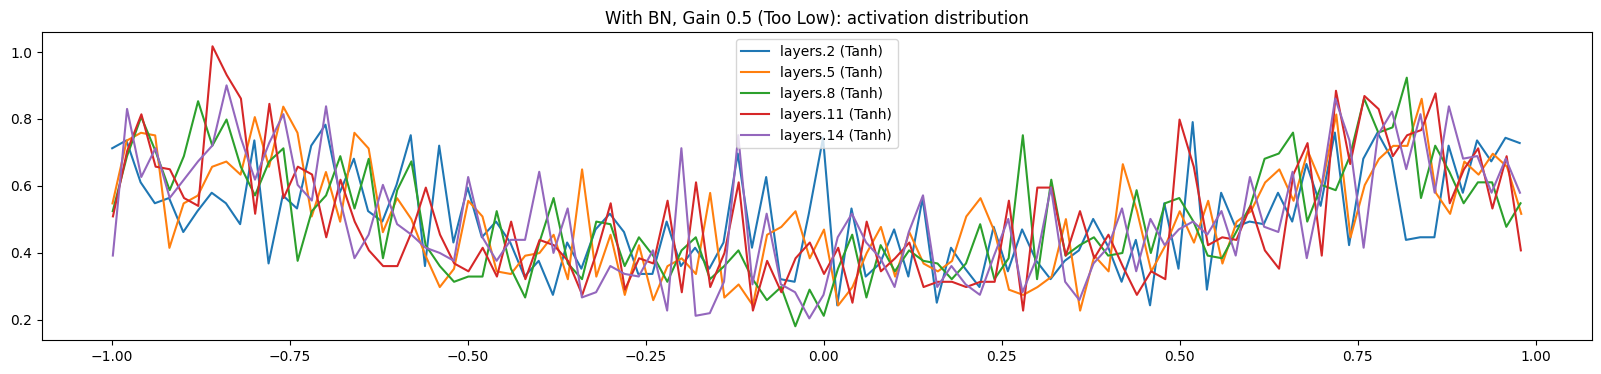

In [96]:
# Visualize activations
visualize_act(hook_wrapper, prepend_str="With BN, Gain 0.5 (Too Low):")

name: layers.2 (Tanh), mean: +0.00, std: 0.01
name: layers.5 (Tanh), mean: +0.00, std: 0.01
name: layers.8 (Tanh), mean: -0.00, std: 0.01
name: layers.11 (Tanh), mean: +0.00, std: 0.00
name: layers.14 (Tanh), mean: -0.00, std: 0.00


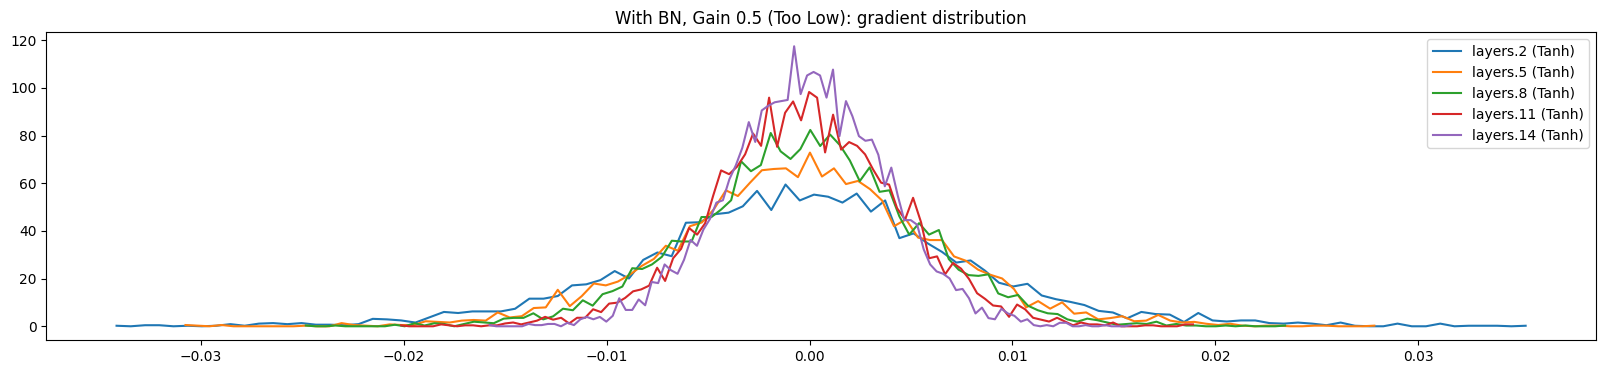

In [97]:
# Visualize activations
visualize_grad(hook_wrapper, prepend_str="With BN, Gain 0.5 (Too Low):")

- **With BN and gain too low**:
    - Very similar to BN with correct gain
    - Good: Still good activations (little saturation), consistent across layers
    - Good: Still good gradients, not too peaked

#### Visualize Part B: With BN, Gain=3
- Single step (`max_steps=1`)
- With bn (`use_bn=True`)
- Reduce last linear weight init: `output_gain=0.1` (less confident)
- Mult. other linear weight init: `force_linear_tanh_gain=3` (gain too large for tanh)

In [98]:
# Forward pass
model, hook_wrapper, step, loss, ud = train_model(
    model_str="MLPv2", 
    train_fn=train_manual, 
    max_steps=1, 
    model_kwargs=dict(use_bn=True, output_gain=0.1, force_linear_tanh_gain=3),  
)

Num params: 173724
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training MLPv2 via train_adam()
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


iter: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s]

Iter [1/1]: loss=3.943, lr=1e-05
Final loss: 3.943085193634033
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


name: layers.2 (Tanh), mean: +0.00, std: 0.63, saturated: 2.98%
name: layers.5 (Tanh), mean: +0.00, std: 0.64, saturated: 2.45%
name: layers.8 (Tanh), mean: +0.00, std: 0.63, saturated: 2.45%
name: layers.11 (Tanh), mean: +0.00, std: 0.64, saturated: 2.55%
name: layers.14 (Tanh), mean: -0.00, std: 0.64, saturated: 2.72%


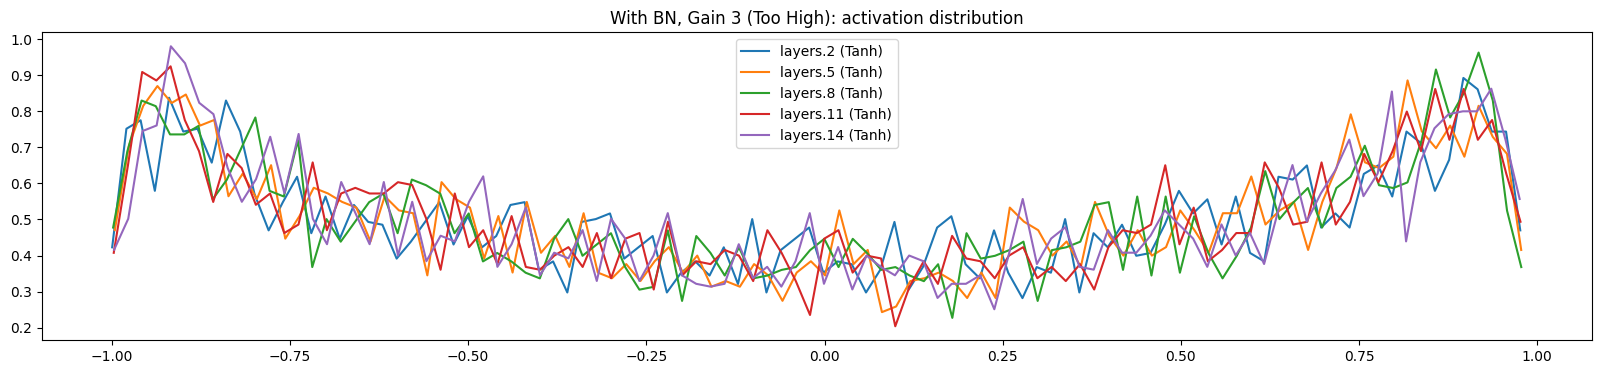

In [99]:
# Visualize activations
visualize_act(hook_wrapper, prepend_str="With BN, Gain 3 (Too High):")

name: layers.2 (Tanh), mean: -0.00, std: 0.01
name: layers.5 (Tanh), mean: -0.00, std: 0.00
name: layers.8 (Tanh), mean: +0.00, std: 0.00
name: layers.11 (Tanh), mean: +0.00, std: 0.00
name: layers.14 (Tanh), mean: -0.00, std: 0.00


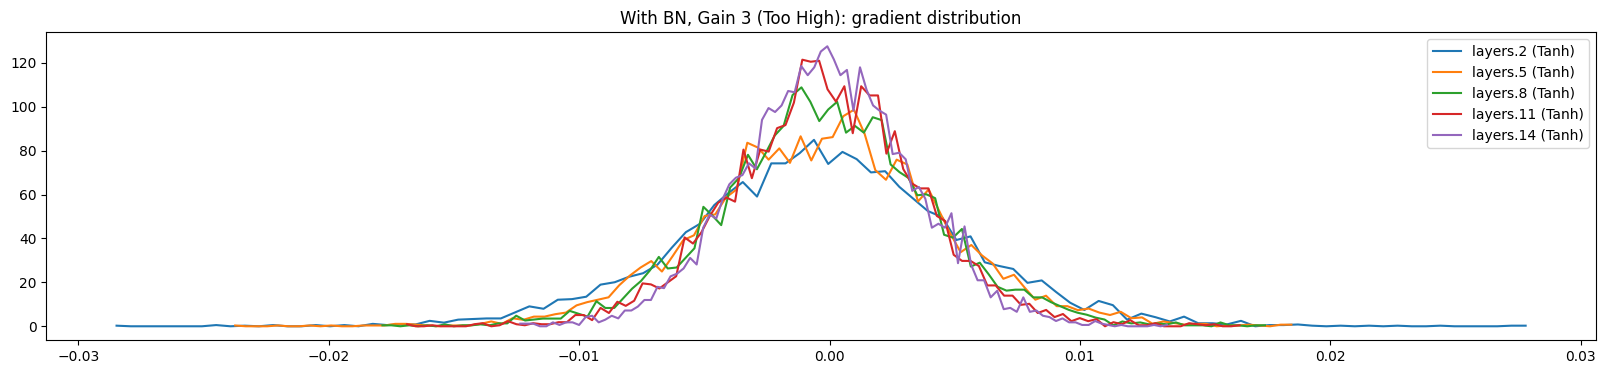

In [100]:
# Visualize activations
visualize_grad(hook_wrapper, prepend_str="With BN, Gain 3 (Too High):")

- **With BN and gain too high**:
    - Very similar to BN with correct gain
    - Good: Still good activations (little saturation), consistent across layers
    - Good: Still good gradients, not too peaked

## Big Picture
- Normalization makes network less fragile, easier to train
- Visualizing activations, gradients, weights and update:data ratios are very helpful
